<a href="https://colab.research.google.com/github/radr44/Iterative_Convolutional_Neural_Network/blob/master/checkpoints/ICNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2 as cv
import torch
import numpy as np
import pywt
import subsampling
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import preprocessing

In [0]:
data_transforms = transforms.Compose([
        transforms.Resize((240,368)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor() ])

In [0]:
data_dir = '/content/drive/My Drive/Superset'
image_dataset = datasets.ImageFolder(data_dir,data_transforms)
class_names = image_dataset.classes
train_set, hold_set = torch.utils.data.random_split(image_dataset, [23582,10000])
val_set, test_set = torch.utils.data.random_split(hold_set, [5000,5000])
dataset_train = torch.utils.data.DataLoader(train_set, batch_size = 4, shuffle = True, num_workers = 4)
dataset_val = torch.utils.data.DataLoader(val_set, batch_size = 4, shuffle = True, num_workers = 4)
dataset_test = torch.utils.data.DataLoader(test_set, batch_size = 4, shuffle = True, num_workers = 4)

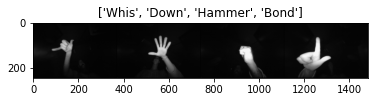

In [15]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataset_train))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

torch.Size([3, 122, 741])


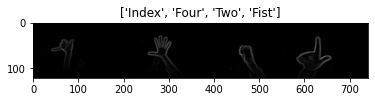

In [16]:
def imgaus(inp, title=None):
    inp = inp.numpy().transpose(1,2,0)
    img = subsampling.wfilter((inp*255).astype(np.uint8),ker=1)
    k =cv.Canny((inp*255).astype(np.uint8), 20,100)
    plt.imshow(img)
    print(torch.from_numpy(img.transpose((2,0,1))).type(torch.float16).shape)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

inputs2, classes = next(iter(dataset_train))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imgaus(out, title=[class_names[x] for x in classes])

In [0]:
class micro_cnn_Alexnet(nn.Module):
  def __init__(self,k=0,nfc=1024):
    super(micro_cnn_Alexnet, self).__init__()
    #k is the f_map count

    self.k = k
    self.nfc = nfc

    self.conv1b = nn.Conv2d(3,24,11,padding=5)
    self.conv2 = nn.Conv2d(24,64,5,padding=2)
    self.conv3 = nn.Conv2d(64,96,3,padding=1)
    self.conv4 = nn.Conv2d(96,48,3,padding=1)
    self.conv5 = nn.Conv2d(48,32,3,padding=1)

    self.fc1 = nn.Linear((32*(self.k+1))*15*23,self.nfc)
    self.fc2 = nn.Linear(self.nfc,self.nfc)
    self.fc3 = nn.Linear(self.nfc,15)

  def forward(self, x, time = 0, n = 0, n_max = 10, fmaps=None, t_max = float('inf'), bgr=True):
    if bgr== True:
      x = F.relu(self.conv1b(x))
  
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = F.max_pool2d(x, 2, 2)
    if fmaps is None:
      fmaps = x
    else:  
      fmaps = torch.cat((fmaps,x), dim=1)
    
    if time>t_max or n==n_max:
      print('classification')
      x = fmaps.view(-1,32*(1+self.k)*15*23) 
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      return F.softmax(x, dim=1)

    else:
      return fmaps  

In [36]:
kil = micro_cnn_Alexnet(3)
kil

micro_cnn_Alexnet(
  (conv1b): Conv2d(3, 24, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (conv2): Conv2d(24, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(96, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(48, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=44160, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=15, bias=True)
)

In [37]:
i=0
for name, param in kil.named_parameters():
    if param.requires_grad:
        i=i+1
        print(i,name)

1 conv1b.weight
2 conv1b.bias
3 conv2.weight
4 conv2.bias
5 conv3.weight
6 conv3.bias
7 conv4.weight
8 conv4.bias
9 conv5.weight
10 conv5.bias
11 fc1.weight
12 fc1.bias
13 fc2.weight
14 fc2.bias
15 fc3.weight
16 fc3.bias


In [0]:
ucnn_1 = micro_cnn_Alexnet(k=0)
ucnn_2 = micro_cnn_Alexnet(k=1)
ucnn_3 = micro_cnn_Alexnet(k=2)
ucnn_4 = micro_cnn_Alexnet(k=3)
ucnn_5 = micro_cnn_Alexnet(k=4)
ucnn_6 = micro_cnn_Alexnet(k=5)
ucnn_7 = micro_cnn_Alexnet(k=6)
ucnn_8 = micro_cnn_Alexnet(k=7)
ucnn_9 = micro_cnn_Alexnet(k=8)
ucnn_10 = micro_cnn_Alexnet(k=9,nfc=2048)
ucnn = [ucnn_1,ucnn_2,ucnn_3,ucnn_4,ucnn_5,ucnn_6,ucnn_7,ucnn_8,ucnn_9,ucnn_10]

In [39]:
a = torch.ones((4,3,120,184))
kil(a,fmaps=torch.ones(4,96,15,23)).shape

torch.Size([4, 128, 15, 23])

In [0]:
class ICNN_Alexnet(nn.Module):
  def __init__(self, ucnn, t_max=float('inf'), n_max=10, batch_size=4):
    super(ICNN_Alexnet, self).__init__()

    self.n_max = n_max
    self.t_max = t_max
    self.batch_size = batch_size 
    self.ucnn = nn.ModuleList(ucnn)

  def forward(self, x):
    temp = time.time() 
    output_f = None
    for i,microcnn in enumerate(self.ucnn):
      input_f = preprocessing.prepare_batch(x,i,self.batch_size)
      output_f = microcnn(input_f.type(torch.float32), time=temp, n=i+1, n_max=self.n_max, fmaps=output_f, t_max=self.t_max)
      
      if temp>self.t_max: 
        return output_f
    return output_f    

In [50]:
icnn=ICNN_Alexnet(ucnn=ucnn)
icnn

ICNN_Alexnet(
  (ucnn): ModuleList(
    (0): micro_cnn_Alexnet(
      (conv1b): Conv2d(3, 24, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
      (conv2): Conv2d(24, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv4): Conv2d(96, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv5): Conv2d(48, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (fc1): Linear(in_features=11040, out_features=1024, bias=True)
      (fc2): Linear(in_features=1024, out_features=1024, bias=True)
      (fc3): Linear(in_features=1024, out_features=15, bias=True)
    )
    (1): micro_cnn_Alexnet(
      (conv1b): Conv2d(3, 24, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
      (conv2): Conv2d(24, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv4): Conv2d(96, 48, kernel_size=(3, 3

In [53]:
icnn(torch.ones((4,3,240,368)))

classification


tensor([[0.0669, 0.0633, 0.0719, 0.0633, 0.0643, 0.0645, 0.0670, 0.0636, 0.0825,
         0.0633, 0.0633, 0.0758, 0.0633, 0.0633, 0.0633],
        [0.0669, 0.0633, 0.0719, 0.0633, 0.0643, 0.0645, 0.0670, 0.0636, 0.0825,
         0.0633, 0.0633, 0.0758, 0.0633, 0.0633, 0.0633],
        [0.0669, 0.0633, 0.0719, 0.0633, 0.0643, 0.0645, 0.0670, 0.0636, 0.0825,
         0.0633, 0.0633, 0.0758, 0.0633, 0.0633, 0.0633],
        [0.0669, 0.0633, 0.0719, 0.0633, 0.0643, 0.0645, 0.0670, 0.0636, 0.0825,
         0.0633, 0.0633, 0.0758, 0.0633, 0.0633, 0.0633]],
       grad_fn=<SoftmaxBackward>)

In [54]:
i=0
for name, param in icnn.named_parameters():
    if param.requires_grad:
        i=i+1
        print(i,name)

1 ucnn.0.conv1b.weight
2 ucnn.0.conv1b.bias
3 ucnn.0.conv2.weight
4 ucnn.0.conv2.bias
5 ucnn.0.conv3.weight
6 ucnn.0.conv3.bias
7 ucnn.0.conv4.weight
8 ucnn.0.conv4.bias
9 ucnn.0.conv5.weight
10 ucnn.0.conv5.bias
11 ucnn.0.fc1.weight
12 ucnn.0.fc1.bias
13 ucnn.0.fc2.weight
14 ucnn.0.fc2.bias
15 ucnn.0.fc3.weight
16 ucnn.0.fc3.bias
17 ucnn.1.conv1b.weight
18 ucnn.1.conv1b.bias
19 ucnn.1.conv2.weight
20 ucnn.1.conv2.bias
21 ucnn.1.conv3.weight
22 ucnn.1.conv3.bias
23 ucnn.1.conv4.weight
24 ucnn.1.conv4.bias
25 ucnn.1.conv5.weight
26 ucnn.1.conv5.bias
27 ucnn.1.fc1.weight
28 ucnn.1.fc1.bias
29 ucnn.1.fc2.weight
30 ucnn.1.fc2.bias
31 ucnn.1.fc3.weight
32 ucnn.1.fc3.bias
33 ucnn.2.conv1b.weight
34 ucnn.2.conv1b.bias
35 ucnn.2.conv2.weight
36 ucnn.2.conv2.bias
37 ucnn.2.conv3.weight
38 ucnn.2.conv3.bias
39 ucnn.2.conv4.weight
40 ucnn.2.conv4.bias
41 ucnn.2.conv5.weight
42 ucnn.2.conv5.bias
43 ucnn.2.fc1.weight
44 ucnn.2.fc1.bias
45 ucnn.2.fc2.weight
46 ucnn.2.fc2.bias
47 ucnn.2.fc3.weight
48

In [0]:
input_f = preprocessing.prepare_batch(torch.ones((4,3,240,368)),0,4)
output_f = ucnn_1(input_f.type(torch.float32), time=0, n=1, n_max=10, fmaps=None)
input_f = preprocessing.prepare_batch(torch.ones((4,3,240,368)),1,4)
output_f = ucnn_2(input_f.type(torch.float32), time=0, n=2, n_max=10, fmaps=output_f)
input_f = preprocessing.prepare_batch(torch.ones((4,3,240,368)),2,4)
output_f = ucnn_3(input_f.type(torch.float32), time=0, n=3, n_max=10, fmaps=output_f)
input_f = preprocessing.prepare_batch(torch.ones((4,3,240,368)),3,4)
output_f = ucnn_4(input_f.type(torch.float32), time=0, n=4, n_max=10, fmaps=output_f)
input_f = preprocessing.prepare_batch(torch.ones((4,3,240,368)),4,4)
output_f = ucnn_5(input_f.type(torch.float32), time=0, n=5, n_max=10, fmaps=output_f)
input_f = preprocessing.prepare_batch(torch.ones((4,3,240,368)),5,4)
output_f = ucnn_6(input_f.type(torch.float32), time=0, n=6, n_max=10, fmaps=output_f)
input_f = preprocessing.prepare_batch(torch.ones((4,3,240,368)),6,4)
output_f = ucnn_7(input_f.type(torch.float32), time=0, n=7, n_max=10, fmaps=output_f)
input_f = preprocessing.prepare_batch(torch.ones((4,3,240,368)),7,4)
output_f = ucnn_8(input_f.type(torch.float32), time=0, n=8, n_max=10, fmaps=output_f)
input_f = preprocessing.prepare_batch(torch.ones((4,3,240,368)),8,4)
output_f = ucnn_9(input_f.type(torch.float32), time=0, n=9, n_max=10, fmaps=output_f)
input_f = preprocessing.prepare_batch(torch.ones((4,3,240,368)),9,4)
output_f = ucnn_10(input_f.type(torch.float32), time=0, n=10, n_max=11, fmaps=output_f)
output_f.size()

torch.Size([4, 320, 15, 23])

In [0]:
input_f = preprocessing.prepare_batch(torch.zeros((4,3,240,368)),1,4)
output_f = ucnn_2(input_f.type(torch.float32), time=0, n=2, n_max=10, fmaps=output_f)



In [0]:
ucnn_1(torch.ones((4,3,120,184)).type(torch.float32)).size()

torch.Size([4, 32, 15, 23])

In [0]:
preprocessing.prepare_batch(inputs,3,4).size()

torch.Size([4, 3, 120, 184])

In [0]:
inputs2[3,:,:,:].size()

torch.Size([3, 240, 368])

In [0]:
inputs.size()

torch.Size([1, 3, 240, 368])